# Replica paper skin (ISIC2017 melanoma task)

## 1. Import packages

In [85]:
################### Basic packages
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
from tqdm import tqdm_notebook
import PIL
#import cv2
from scipy.stats import skew, kurtosis                         # Color feature (3rd moment)
from skimage.feature.texture import greycomatrix, greycoprops  # Texture features
from skimage.measure import shannon_entropy                    # Texture features (entropy)

################### ML packages
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC                                    # Support vector machine
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import KernelPCA

################### DL packages
import fastai
from   fastai.vision import *

%matplotlib inline
print("Versions:")
print("\tPillow       ", PIL.__version__)
print("\tScikit-learn ", sklearn.__version__)
print("\tFast.ai      ", fastai.__version__)

Versions:
	Pillow        5.4.1
	Scikit-learn  0.20.1
	Fast.ai       1.0.46


## 2. Read data

In [55]:
path     = pathlib.Path("E:/Datasets/TFM/ISIC-2017")
df_train = pd.read_csv(path / ("ground_truth_train.csv"))
df_valid = pd.read_csv(path / ("ground_truth_valid.csv"))
df_test  = pd.read_csv(path / ("ground_truth_test.csv"))

print("Train dataset", len(df_train), "images.")
print("Valid dataset", len(df_valid), "images.")
print("Test  dataset", len(df_test), "images.")

#df = df.replace({'melanoma': {0.0:"no", 1.0:"yes"}})
df_train[["melanoma", "seborrheic_keratosis"]] = df_train[["melanoma", "seborrheic_keratosis"]].astype(int)
df_valid[["melanoma", "seborrheic_keratosis"]] = df_valid[["melanoma", "seborrheic_keratosis"]].astype(int)
df_test[ ["melanoma", "seborrheic_keratosis"]] = df_test[ ["melanoma", "seborrheic_keratosis"]].astype(int)

# Merge
#df = pd.concat([df_train, df_valid, df_test], ignore_index=True)
#src  = ImageItemList.from_df(df, path, suffix=".jpg")

print("\nFirst 5 rows of the train dataset:")
df_train.head()

Train dataset 2000 images.
Valid dataset 150 images.
Test  dataset 600 images.

First 5 rows of the train dataset:


,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0,0
1,ISIC_0000001,0,0
2,ISIC_0000002,1,0
3,ISIC_0000003,0,0
4,ISIC_0000004,1,0


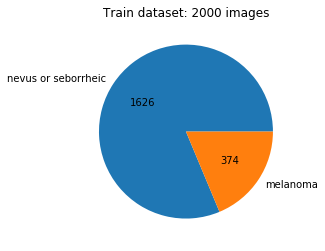

In [56]:
pct = lambda p: '{:.0f}'.format(p * 2000 / 100)
labels = ["nevus or seborrheic", 'melanoma']
df_train['melanoma'].value_counts().plot.pie(labels=labels, autopct=pct); plt.ylabel('')
plt.title('Train dataset: 2000 images');

## 3. Preprocess dataset
- Compute average **mean** and **std** of the images for normalize later
- Stratified 10 fold cross validation
- Transform to get a 140x140 size
- Random horizontal and vertical flips

In [6]:
###################################### Stratified 10 Fold Cross validation indexes
n_cv_folds = 10
x = df_train.image_id.values
y = df_train.melanoma.values
train_idxs_fold = []
valid_idxs_fold = []

cross_valid = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=0) # Always same random stratified CV
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    train_idxs_fold.append(train_index)
    valid_idxs_fold.append(valid_index)

###################################### Get mean and std
#mean = np.zeros(3)  # float64
#std  = np.zeros(3)  # float64
#for img in tqdm_notebook(train):
#    mean += img.data.numpy().mean(axis=(1,2)) # float32
#    std  += img.data.numpy().std(axis=(1,2)) 
#mean /= len(train)
#std  /= len(train)
ISIC2017_mean  = [0.689854, 0.585559, 0.543878]
ISIC2017_std   = [0.10585 , 0.114173, 0.127212]

##################################### Src data
src_train = ImageList.from_df(df_train, path, folder='data_train', suffix=".jpg")
src_valid = ImageList.from_df(df_valid, path, folder='data_valid', suffix=".jpg")
src_test  = ImageList.from_df(df_test,  path, folder='data_test',  suffix=".jpg")

data = (src_train.split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0]) # src_train.no_split(); src.valid = valid
        .label_from_df(cols='melanoma')
        .transform(get_transforms(flip_vert=True, max_warp=None), size=140)
        .databunch(bs=16)
        .normalize((ISIC2017_mean, ISIC2017_std)))

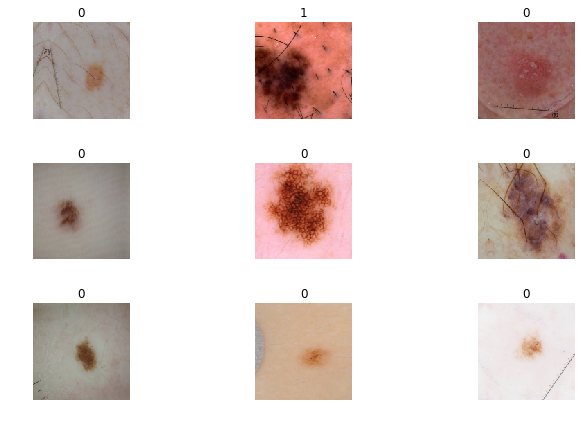

In [6]:
data.show_batch(rows=3, figsize=(10,6))

## Extract traditional features

- **Texture features**: 8 matrices * 4 features each = 32 total features
  - First acquire the gray-level co-occurrence matrix G (2 distances, 4 angles = 2*4 = 8 matrices)
  - Then, we employ:
    - **Angular second moment** (ASM)
    - **Entropy** (ENT)
    - **Contrast** (CON)
    - **Correlation** (COR)
- **Color moment features**: For each RGB channel compute 3 features: 3x3 = 9 features:
  - First color moment (**Mean**)
  - Second color moment (**Std**)
  - Third color moment (**Skewness**)

In [82]:
def texture_features(pil_img):
    
    # Read image in black and white (np array of 2 dimensions)
    # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # A bit different b&w values
    img = pil_img.convert("L")
    img = np.array(img)

    # Get Gray-Level Co-Occurrence Matrix from the image (2 distances, 4 angles = 2*4 = 8 matrices)
    distances  = [1,2]
    angles     = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0, 45, 90, 135 degree in radians.
    glcm = greycomatrix(img, distances, angles)
    #print("GLCM shape:", glcm.shape)

    # Get properties from glcm. (Entropy feature is not available in the greycoprops method)
    properties = ['ASM', 'contrast'] #properties = ['ASM', 'contrast', 'correlation']
    some_texture_feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])

    entropy_feat = [shannon_entropy(glcm[:,:,x,y])  for x in range(2)   for y in range(4)]

    return np.hstack([some_texture_feats, entropy_feat])
    
def color_features(pil_img):

    np_image = np.array(pil_img)
    mean     = np.mean(np_image, axis=(0,1))                           # First color moment (Mean)
    std      = np.std(np_image, axis=(0,1))                            # Second color moment (std)
    skewness = [skew(np_image[:, :, c].reshape(-1)) for c in range(3)] # Third color moment (Skewness)

    return np.hstack([mean, std, skewness])

def traditional_features(imageList):
    
    num_samples = len(imageList)
    feats = np.empty([num_samples, 33]) # 41
    
    for i in tqdm_notebook(range(num_samples)):
        image    = PIL.Image.open(imageList.items[i])
        feats[i] = np.hstack([texture_features(image), color_features(image)])
        
    return feats

#feats = traditional_features(src_train); np.save('skinTrain_x_low.npy', feats)
#feats = traditional_features(src_valid); np.save('skinValid_x_low.npy', feats)
#feats = traditional_features(src_test);  np.save('skinTest_x_low.npy',  feats)

# Models
- Trad feats (color & texture) with **SVM**
- Deep feats (CNN penultimate layer) with **Coding network**
- Fusion methods (both trad & deep feats)
  - **CNMP**: (multilayer perceptron as fusion method)
  - **R**: (manully fixed parameter) (log regr)
  - **KPCA**: KPCA and linear SVM
  - **SVM**: RBF SVM
  
  
# MODEL 1: SVM with trad feats

In [83]:
x = np.load('features/skinTrain_x_low.npy')
x = StandardScaler().fit_transform(x)
y = df_train["melanoma"].values

print("Data shape: x =", x.shape, "y =", y.shape)

Data shape: x = (2000, 33) y = (2000,)


In [37]:
model = SVC(kernel='rbf', random_state=0, probability=True)
parameter_grid = {'class_weight': [None, 'balanced'],
                  'C':            [0.1, 1.0, 5.0, 10.0, 100.0, 1000.0],
                  'gamma':        [0.0001, 0.001, 0.01, 0.1, 1.0, 'auto', 'scale']
                 }

parameter_grid = {'class_weight': ['balanced'],
                  'probability':  [True],
                  'C':            [10, 100, 1000, 10000],
                  'gamma':        [0.0001, 0.001, 0.01, 0.1, 'auto', 'scale']
                 }

#grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=True)

grid_search.fit(x, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   50.0s finished


Best score: 0.5586824452083041
Best parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 0.001, 'probability': True}


### Evaluate best model

In [8]:
def plot_roc(y_valid, y_pred, ax=None, figsize=(5,5)):

    if ax is None: fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    ax.set_title('ROC Curve')
    ax.plot(fpr, tpr, 'darkorange', label = 'AUC = %0.4f' % roc_auc)
    ax.legend(loc = 'lower right', fontsize="large")
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlim([-0.005, 1])
    ax.set_ylim([0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return ax

Fold 1   AUC: 0.696964804649661
Fold 2   AUC: 0.6289958023894091
Fold 3   AUC: 0.5616725863739103
Fold 4   AUC: 0.7820471423958669
Fold 5   AUC: 0.6919250538882441
Fold 6   AUC: 0.6587630575360637
Fold 7   AUC: 0.5764097430764098
Fold 8   AUC: 0.6618284951618285
Fold 9   AUC: 0.6327994661327995
Fold 10   AUC: 0.664330997664331
Accuracy:         0.6135
Accuracy (balan): 0.6192141734251566
AUC:              0.653799225158027
F1 score:         0.37811745776347544
Confusion matrix:
 [[992 634]
 [139 235]]


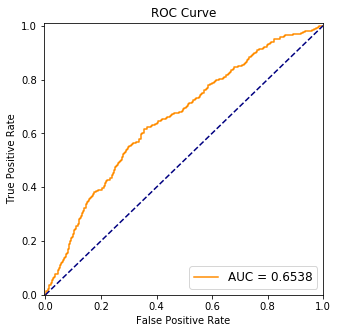

In [42]:
preds = np.array([])
preds_probs = np.array([])
reals = np.array([])

for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    
    ########################################################## GET K-FOLD DATA
    x_train, y_train = x[train_index], y[train_index]
    x_valid, y_valid = x[valid_index], y[valid_index]
    
    ########################################################## TRAIN
    #model = SVC(class_weight='balanced', probability=True)
    #model = SVC(kernel='rbf', class_weight='balanced', C=1, gamma='scale', probability=True, random_state=0) # 0.6549
    #model = SVC(kernel='rbf', class_weight='balanced', C=10,  gamma=0.001, probability=True, random_state=0) # 0.6537
    model = SVC(kernel='rbf', class_weight='balanced', C=1000, gamma=0.001, probability=True, random_state=0) # 0.6537
    model.fit(x_train, y_train)  # Train the SVM

    ########################################################## EVALUATE
    p  = model.predict(x_valid)
    pp = model.predict_proba(x_valid)[:,1]
    preds = np.append(preds, p)
    preds_probs = np.append(preds_probs, pp)
    reals = np.append(reals, y_valid)
    print("Fold", i+1, "  AUC:", metrics.roc_auc_score(y_valid, pp))


print("================================")
print("Accuracy:        ", metrics.accuracy_score(reals, preds))
print("Accuracy (balan):", metrics.balanced_accuracy_score(reals, preds))
print("AUC:             ", metrics.roc_auc_score(reals, preds_probs))
print("F1 score:        ", metrics.f1_score(reals, preds))
#print("Precision:      ", metrics.precision_score(reals, preds))
#print("Recall:         ", metrics.recall_score(reals, preds))
print("Confusion matrix:\n", metrics.confusion_matrix(reals, preds))
plot_roc(reals, preds_probs);

# MODEL 2: Coding Network (cnn)

- [Custom model with fast.ai](https://forums.fast.ai/t/so-you-want-to-create-your-custom-pipeline-with-fastai/17182/11)


Input size of `3×140×140`

Layer       | Kernel | Stride | Output size
------------|--------|--------|------------
Convolution | 11×11  |    1   | 32×130×130
Convolution | 11×11  |    1   | 32×120×120
Max pooling | 5×5    |    2   | 32×58×58
Convolution | 9×9    |    1   | 64×50×50
Max pooling | 5×5    |    2   | 64×23×23
Convolution | 8×8    |    1   | 128×16×16
Convolution | 9×9    |    1   | 256×8×8
Convolution | 8×8    |    1   | 256×1×1
Dense       |    -   |    -   | 4×1×1
Softmax     |    -   |    -   | 4×1×1

In [90]:
##################################################### Fastai AUC ROC fix
def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return metrics.roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_target, last_output, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            self.learn.recorder.add_metrics([metric])

In [91]:
def conv(in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0),
        nn.BatchNorm2d(out_channels),
        # nn.Dropout2d(p=0.05),
        nn.ReLU())

CodingNetwork = nn.Sequential(
	conv(3,  32, kernel_size=11),
	conv(32, 32, kernel_size=11),
	nn.MaxPool2d(kernel_size=5, stride=2, padding=0),
	conv(32, 64, kernel_size=9),
	nn.MaxPool2d(kernel_size=5, stride=2, padding=0),
	conv(64,  128, kernel_size=8),
	conv(128, 256, kernel_size=9),
	conv(256, 256, kernel_size=8),
	Flatten(),
	nn.Linear(256, 2)
)

learn = Learner(data, CodingNetwork, metrics=accuracy, callback_fns=AUROC)
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 32, 130, 130]    11,648     True      
______________________________________________________________________
BatchNorm2d          [1, 32, 130, 130]    64         True      
______________________________________________________________________
ReLU                 [1, 32, 130, 130]    0          False     
______________________________________________________________________
Conv2d               [1, 32, 120, 120]    123,936    True      
______________________________________________________________________
BatchNorm2d          [1, 32, 120, 120]    64         True      
______________________________________________________________________
ReLU                 [1, 32, 120, 120]    0          False     
______________________________________________________________________
MaxPool2d            [1, 32, 58, 58]      0          False     
______________________________________________________________

### Balance loss function (class-weighted CrossEntropyLoss)

In [9]:
df_train['melanoma'].value_counts()

0    1626
1     374
Name: melanoma, dtype: int64

In [10]:
#     [negativos=1626,  melanomas=374]
weights1 = [1/1626,   1/374]      # Option 1 [0.0006, 0.0027]
weights2 = [374/2000, 1626/2000]  # Option 2 [0.187,  0.813]
weights  = torch.FloatTensor(weights2).cuda()

learn.loss_func = CrossEntropyFlat(weight=weights)

### Find best maximun learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04


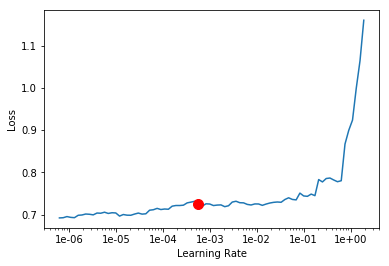

In [16]:
learn.lr_find()
learn.recorder.plot()

### Train 45 epochs

In [12]:
learn.fit_one_cycle(45, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,AUROC
1,0.708176,0.696664,0.437811,0.562641
2,0.691426,0.702422,0.462687,0.604940
3,0.693323,0.681559,0.786070,0.576364
4,0.688932,0.679944,0.532338,0.607523
5,0.683806,0.740350,0.412935,0.458831
6,0.687902,0.723653,0.696517,0.552632
7,0.689716,0.673506,0.651741,0.607523
8,0.679684,0.670936,0.696517,0.620762
9,0.687101,0.670417,0.696517,0.613174
10,0.682108,0.684499,0.532338,0.582338


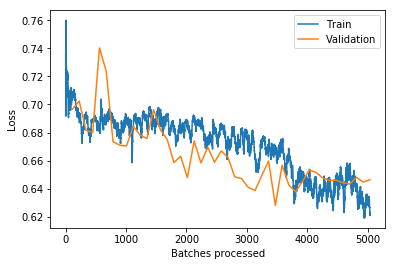

In [13]:
learn.recorder.plot_losses()

In [94]:
#learn.recorder.plot_metrics() # First is accuracy, second is AUC

In [14]:
learn.save("Melan-45eps-Fold1")

## Test (with the first cv-fold of the train dataset)

In [92]:
learn.load("Melan-45eps-Fold1");

In [14]:
preds,    y    = learn.get_preds()
preds = preds[:,1].numpy()
y     = y.numpy()

Accuracy:  0.6865671641791045
AUC ROC:   0.6435259928963513
F1 score:  0.35051546391752586
Precision: 0.288135593220339
Recall:    0.4473684210526316
Confusion matrix:
 [[121  42]
 [ 21  17]]


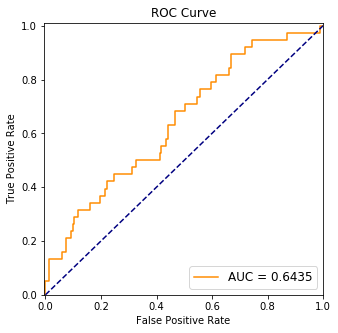

In [16]:
print("Accuracy: ", metrics.accuracy_score(y, preds.round()))
print("AUC ROC:  ", metrics.roc_auc_score(y, preds))
print("F1 score: ", metrics.f1_score(y, preds.round()))
print("Precision:", metrics.precision_score(y, preds.round()))
print("Recall:   ", metrics.recall_score(y, preds.round()))
print("Confusion matrix:\n", metrics.confusion_matrix(y, preds.round()))
plot_roc(y, preds);

## Test Time Augmentation

In [62]:
predsTTA, yTTA = learn.TTA(beta=0.2, scale=1)

In [63]:
y = yTTA.numpy()
p = predsTTA[:,1].numpy()

metrics.roc_auc_score(y, p)

0.42686470778172425

# Save high (cnn) features

In [11]:
data = (src_train.no_split()
        .label_from_df(cols='melanoma')
        .transform(([],[]), size=140)
        .databunch(bs=16)
        .normalize((ISIC2017_mean,ISIC2017_std)))

learn.load("Melan-45eps-Fold1");

In [12]:
def high_features(dataset, model):
    
    num_samples = len(dataset)
    h_feats = np.empty([num_samples, 256])
    
    model.eval()
    model = model[:-1]
    
    for i in tqdm_notebook(range(num_samples)):
        
        img_tnsr   = dataset[i][0].data.cuda()[None,:]         # [1, 3, 140, 140] cuda tensor
        h_feats[i] = model(img_tnsr)[0].cpu().detach().numpy() # [256] cpu numpy

    return h_feats

h_feats = high_features(data.train_ds, learn.model)
np.save('features/melan_x_high.npy', h_feats)

# Fusion methods

In [34]:
x_low  = np.load('features/skin_x_low.npy')
x_high = np.load('features/skin_x_highMela.npy')
y      = df_train["melanoma"].values

#low_scaled = preprocessing.scale(low)
x_low = preprocessing.StandardScaler().fit_transform(x_low) # Normalice
x_fusion = np.concatenate((x_low, x_high), axis=1)


############################## Split in train-val
train_idxs = train_idxs_fold[0]
valid_idxs = valid_idxs_fold[0]
x_train, y_train = x_fusion[train_idxs], y[train_idxs]
x_valid, y_valid = x_fusion[valid_idxs], y[valid_idxs]

print("Low features:\tShape:", x_low.shape,   "\t Min:", x_low.min(), "\t Max:", x_low.max())
print("High features:\tShape:", x_high.shape, "\t Min:", x_high.min(), "\t\t\t Max:", x_high.max())
print("Fusion feats:\tShape:", x_fusion.shape, "\t Min:", x_fusion.min(), "\t Max:", x_fusion.max())

Low features:	Shape: (2000, 33) 	 Min: -5.011059247850769 	 Max: 11.601424261926983
High features:	Shape: (2000, 256) 	 Min: 0.0 			 Max: 3.2685275077819824
Fusion feats:	Shape: (2000, 289) 	 Min: -5.011059247850769 	 Max: 11.601424261926983


# Fusion: R
### Objetivo `xxx` -> Obtengo `xxx`

In [30]:
#model = MLPClassifier(hidden_layer_sizes=(), max_iter=10000, validation_fraction=0)
model = LogisticRegression(C=1e6, solver='lbfgs', class_weight='balanced', max_iter=10000, random_state=0)
model.fit(x_train, y_train)

C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [31]:
y_pred = model.predict_proba(x_valid)[:,1]

print("Accuracy: ", metrics.accuracy_score(y_valid, y_pred.round()))
print("AUC ROC:  ", metrics.roc_auc_score(y_valid, y_pred))
print("Confusion matrix:\n", metrics.confusion_matrix(y_valid, y_pred.round()))

Accuracy:  0.6467661691542289
AUC ROC:   0.6596706490151759
Confusion matrix:
 [[108  55]
 [ 16  22]]


# Fusion: MLP
### Objetivo `xx.x` -> Obtengo `xx.x`

In [35]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(170), max_iter=1000, validation_fraction=0, random_state=0) # 150, 200 hl works good
model.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=170, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0, verbose=False, warm_start=False)

In [36]:
y_pred = model.predict_proba(x_valid)[:,1]

print("Accuracy: ", metrics.accuracy_score(y_valid, y_pred.round()))
print("AUC ROC:  ", metrics.roc_auc_score(y_valid, y_pred))
print("Confusion matrix:\n", metrics.confusion_matrix(y_valid, y_pred.round()))

Accuracy:  0.746268656716418
AUC ROC:   0.6503067484662577
Confusion matrix:
 [[137  26]
 [ 25  13]]


# Fusion: SVM
### Objetivo `xx.x`  -> Obtengo `xx.x`

In [41]:
model = SVC(kernel='rbf', random_state=0, probability=True)
parameter_grid = {'class_weight': [None, 'balanced'],
                  'C':            [0.1, 1.0, 5.0, 10.0, 100.0, 1000.0],
                  'gamma':        [0.0001, 0.001, 0.01, 0.1, 1.0, 'auto', 'scale']
                 }

parameter_grid = {'class_weight': ['balanced'],
                  'C':            [10, 100, 1000],
                  'gamma':        [0.0001, 0.001, 0.01, 0.1, 'auto', 'scale']
                 }
grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=True)
grid_search.fit(x_train, y_train)
print('Best score:',      grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.5s finished


Best score: 0.6237178044456467
Best parameters: {'C': 100, 'class_weight': 'balanced', 'gamma': 0.0001}


In [42]:
model = SVC(kernel='rbf', C=100, gamma=0.001, class_weight='balanced', probability=True)
model.fit(x_train, y_train)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
y_pred = model.predict_proba(x_valid)[:,1]

print("Accuracy: ", metrics.accuracy_score(y_valid, y_pred.round()))
print("AUC ROC:  ", metrics.roc_auc_score(y_valid, y_pred))
print("Confusion matrix:\n", metrics.confusion_matrix(y_valid, y_pred.round()))

Accuracy:  0.8140703517587939
AUC ROC:   0.6758425091758425
Confusion matrix:
 [[162   0]
 [ 37   0]]


# Fusion: KPCA
PCA with RBF kernel
### Objetivo `xx.x`  -> Obtengo `xx.x`

In [44]:
kpca         = KernelPCA(kernel="rbf")#, gamma=10)
x_train_kpca = kpca.fit_transform(x_train)

model = SVC(kernel='linear', C=10, gamma=0.1, class_weight='balanced', probability=True) # Linear SVM
model.fit(x_train_kpca, y_train)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
x_valid_kpca = kpca.transform(x_valid)
y_pred = model.predict_proba(x_valid_kpca)[:,1]

print("Accuracy: ", metrics.accuracy_score(y_valid, y_pred.round()))
print("AUC ROC:  ", metrics.roc_auc_score(y_valid, y_pred))
print("Confusion matrix:\n", metrics.confusion_matrix(y_valid, y_pred.round()))

Accuracy:  0.8140703517587939
AUC ROC:   0.6049382716049383
Confusion matrix:
 [[162   0]
 [ 37   0]]


## Todos

In [45]:
x_low    = np.load('features/skinTrain_x_low.npy'); x_low = preprocessing.StandardScaler().fit_transform(x_low)
x_high   = np.load('features/skinTrain_x_highMela.npy')
y        = df_train["melanoma"].values
x_fusion = np.concatenate((x_low, x_high), axis=1)

############################## Split in train-val
train_idxs = train_idxs_fold[0]
valid_idxs = valid_idxs_fold[0]
x_train, y_train = x_fusion[train_idxs], y[train_idxs]
x_valid, y_valid = x_fusion[valid_idxs], y[valid_idxs]

print("Low features:\tShape:",  x_low.shape,   "\t Min:", x_low.min(),   "\t Max:", x_low.max())
print("High features:\tShape:", x_high.shape,  "\t Min:", x_high.min(),  "\t\t\t Max:", x_high.max())
print("Fusion feats:\tShape:",  x_fusion.shape,"\t Min:", x_fusion.min(),"\t Max:", x_fusion.max())

Low features:	Shape: (2000, 33) 	 Min: -5.011059247850769 	 Max: 11.601424261926983
High features:	Shape: (2000, 256) 	 Min: 0.0 			 Max: 3.2685275077819824
Fusion feats:	Shape: (2000, 289) 	 Min: -5.011059247850769 	 Max: 11.601424261926983


In [105]:
######################################################### TRAD SVM
x_train, y_train = x_low[train_idxs], y[train_idxs]
x_valid, y_valid = x_low[valid_idxs], y[valid_idxs]

m1 = SVC(kernel='rbf', class_weight='balanced', C=1000, gamma=0.001, probability=True, random_state=0) # 0.6537
m1.fit(x_train, y_train)  # Train the SVM
p1 = m1.predict_proba(x_valid)[:,1]

In [56]:
######################################################### HIGH CNN
x_train, y_train = x_high[train_idxs], y[train_idxs]
x_valid, y_valid = x_high[valid_idxs], y[valid_idxs]

learn.load("Melan-45eps-Fold1")
learn.data = (src_train.split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0]) # src_train.no_split(); src.valid = valid
        .label_from_df(cols='melanoma')
        .transform(get_transforms(flip_vert=True, max_warp=None), size=140)
        .databunch(bs=16)
        .normalize((ISIC2017_mean,ISIC2017_std)))
preds,_   = learn.get_preds()
p2 = preds[:,1].numpy()

In [85]:
######################################################### FUS SVM
x_train, y_train = x_fusion[train_idxs], y[train_idxs]
x_valid, y_valid = x_fusion[valid_idxs], y[valid_idxs]

m3 = SVC(kernel='rbf', class_weight='balanced', C=1000, gamma=0.001, probability=True, random_state=0) # 0.6537
m3.fit(x_train, y_train)
p3 = m3.predict_proba(x_valid)[:,1]

In [86]:
######################################################### R
x_train, y_train = x_fusion[train_idxs], y[train_idxs]
x_valid, y_valid = x_fusion[valid_idxs], y[valid_idxs]

m4 = MLPClassifier(hidden_layer_sizes=(170), max_iter=1000, validation_fraction=0, random_state=0) # 150, 200 hl works good
m4.fit(x_train, y_train)
p4 = m4.predict_proba(x_valid)[:,1]

In [115]:
######################################################### MLP
x_train, y_train = x_fusion[train_idxs], y[train_idxs]
x_valid, y_valid = x_fusion[valid_idxs], y[valid_idxs]

m5 = LogisticRegression(C=1e6, solver='lbfgs', class_weight='balanced', max_iter=10000, random_state=0)
m5.fit(x_train, y_train)
p5 = m5.predict_proba(x_valid)[:,1]

C:\Users\Javi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [120]:
######################################################### KPCA
x_train, y_train = x_fusion[train_idxs], y[train_idxs]
x_valid, y_valid = x_fusion[valid_idxs], y[valid_idxs]

kpca         = KernelPCA(kernel="rbf")#, gamma=10)
x_train_kpca = kpca.fit_transform(x_train)
m6 = SVC(kernel='linear', C=10, gamma=0.1, class_weight='balanced', probability=True) # Linear SVM
m6.fit(x_train_kpca, y_train)

x_valid_kpca = kpca.transform(x_valid)
p6 = m6.predict_proba(x_valid_kpca)[:,1]

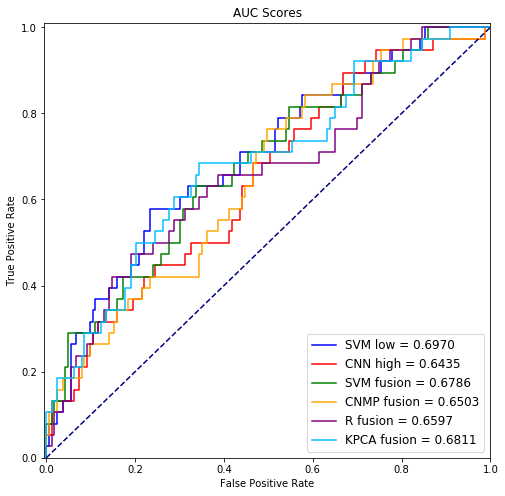

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

######################################################### M1
fpr, tpr, threshold = metrics.roc_curve(y_valid, p1); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="b", label = 'SVM low = %0.4f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(y_valid, p2); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="r", label = 'CNN high = %0.4f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(y_valid, p3); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="g", label = 'SVM fusion = %0.4f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(y_valid, p4); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="orange", label = 'CNMP fusion = %0.4f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(y_valid, p5); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="purple", label = 'R fusion = %0.4f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(y_valid, p6); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="deepskyblue", label = 'KPCA fusion = %0.4f' % roc_auc)

ax.set_title('AUC Scores')
ax.legend(loc = 'lower right', fontsize="large")
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlim([-0.005, 1])
ax.set_ylim([0, 1.01])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate');